# Gaussian Processes

This workbook will implement a Gaussian Process model using the TensorFlow toolkit!

We will

- Implement a numpy function that evaluates the squared exponential kernel using for loops and use it to check that the tensorflow function provided is correct

- Get the GP regression code running on a toy example with a Gaussian likelihood

- Run the code on traffic count data (the training outputs are integers) and observe what happens. 

- Implement a periodic kernel to replace the squared exponential kernel and run the regression model with the new kernel. 


- Modify the original GP regression code to implement the Poisson likelihood GP and run it on the count data with the squared exponential kernel.

- Run the Poisson GP with the periodic kernel

In [23]:
# Import statements..

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

dtype = tf.float64
dtype_convert = tf.to_double

np.random.seed(0)

## Squared Exponential Covariance Kernel

The following tensorflow code evaluates a squared exponential covariance in **vectorised** form (more efficient computation).

In [2]:
def get_lengthscale_euclid_sq_dist(t_X, t_Z, t_lengthscale):
    t_inv_lengthscale_squared = 1.0 / tf.square(t_lengthscale)


    xx = t_inv_lengthscale_squared * tf.reduce_sum(t_X * t_X, axis=1, keep_dims=True)
    
    zz = t_inv_lengthscale_squared * tf.reduce_sum(t_Z * t_Z, axis=1, keep_dims=True)

    
    return xx + tf.transpose(zz) - 2.0 * t_inv_lengthscale_squared * tf.matmul(t_X, t_Z, transpose_b=True)
    #return xx + tf.transpose(zz)# - 2.0 * t_inv_lengthscale_squared * tf.matmul(t_X, t_Z, transpose_b=True)

def create_squared_exp_kernel(t_X1, t_X2, t_signal_variance, t_lengthscale):
    dist_x1x2_sq = get_lengthscale_euclid_sq_dist(t_X1, t_X2, t_lengthscale)
    
    return t_signal_variance * tf.exp(- 0.5 * dist_x1x2_sq)

Next we implement a function that calculates the squared exponential kernel in numpy using for loops and use it to check that the TensorFlow code operates correctly.

In [3]:
def numpy_squared_exp_kernel(X, signal_variance, lengthscale):
    
    #build symetric matrix calculating the squared kernal between each point

    K = np.zeros((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            xDiffsqrt =  (np.absolute(X[i]-X[j]))**2

            K[i,j] = signal_variance*np.exp((-1/(2*lengthscale**2))*xDiffsqrt)
    
    return K

# Testing part:
lengthscale = 2.3
signal_variance = 1.4

N = 5
X = np.random.randn(N,1)


tf.reset_default_graph()
with tf.Session() as session:
    t_lengthscale = tf.constant(lengthscale, dtype=dtype)
    t_signal_variance = tf.constant(signal_variance, dtype=dtype)
    
    
    t_X = tf.constant(X, dtype=dtype)
    
    t_K = create_squared_exp_kernel(t_X1=t_X, 
                                    t_X2=t_X, 
                                    t_signal_variance=t_signal_variance,
                                    t_lengthscale=t_lengthscale)
    
    print('TensorFlow K =\n', session.run(t_K))
    
    numpy_K = numpy_squared_exp_kernel(X=X, 
                                      signal_variance=signal_variance, 
                                      lengthscale=lengthscale)
    
    print('Numpy checking code K = \n', numpy_K)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
TensorFlow K =
 [[1.4        1.17427272 1.32072556 1.37023329 1.39858306]
 [1.17427272 1.4        1.35639685 1.01634838 1.14219291]
 [1.32072556 1.35639685 1.4        1.20430393 1.2992705 ]
 [1.37023329 1.01634838 1.20430393 1.4        1.38167758]
 [1.39858306 1.14219291 1.2992705  1.38167758 1.4       ]]
Numpy checking code K = 
 [[1.4        1.17427272 1.32072556 1.37023329 1.39858306]
 [1.17427272 1.4        1.35639685 1.01634838 1.14219291]
 [1.32072556 1.35639685 1.4        1.20430393 1.2992705 ]
 [1.37023329 1.01634838 1.20430393 1.4        1.38167758]
 [1.39858306 1.14219291 1.2992705  1.38167758 1.4       ]]


## GP Regression Model

The following is TensorFlow code that implements a regression GP model with a Gaussian likelihood. Note that we optimise the **negative log likelihood** in TensorFlow since the optimiser **minimises** the objective function.

In [4]:
# A wrapper function to create a real number variable (-infinity, infinity)
# with an initial value that will be optimised by tensorflow.
def create_real_variable(initial_value):
    return tf.Variable(initial_value, dtype=dtype)

# A wrapper function to create a positive variable (0, infinity) by
# taking the exp() of a real number - this will map the real range to
# the set of positive numbers.
def create_positive_variable(initial_value):
    assert initial_value > 0.0
    return tf.exp(tf.Variable(np.log(initial_value), dtype=dtype))
    #return tf.exp(tf.Variable(np.log(initial_value), dtype=tf.float32))
    
# A Gaussian Process class to keep all the parts of the model we need
# grouped together
class GP:
    def __init__(self,
                 description,
                 t_objective,
                 create_prediction_function,
                 t_prediction_placeholder,
                 t_prediction_mean,
                 t_prediction_var,
                 t_input=None,
                 t_output=None,
                 hyperparameter_dict={}):

        self._description = description
        self._t_objective = t_objective
        self._create_prediction_function = create_prediction_function
        self._t_prediction_placeholder = t_prediction_placeholder
        self._t_prediction_mean = t_prediction_mean
        self._t_prediction_var = t_prediction_var
        self._t_input = t_input
        self._t_output = t_output
        self._hyperparameter_dict = hyperparameter_dict

    @property
    def description(self): return self._description

    @property
    def t_objective(self): return self._t_objective

    @property
    def t_prediction_placeholder(self): return self._t_prediction_placeholder

    @property
    def t_prediction_mean(self): return self._t_prediction_mean

    @property
    def t_prediction_var(self): return self._t_prediction_var

    @property
    def t_input(self): return self._t_input

    @property
    def t_output(self): return self._t_output

    @property
    def hyperparameter_dict(self): return self._hyperparameter_dict

    def create_prediction(self, tf_input):
        return self._create_prediction_function(tf_input)
    

# Create a GP regression model by specifying the input and output data, as (N x 1) matrices,
# and the initial values for the hyperparameters (these will be turned into tensorflow variables
# and optimised).
def create_gp(input_data, 
              output_data, 
              initial_signal_variance,
              initial_lengthscale,
              initial_sigma_noise_sq):

    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    t_lengthscale = create_positive_variable(initial_lengthscale)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    
    sess = tf.Session()
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'lengthscale': t_lengthscale,
                           'sigma_noise_squared': t_sigma_noise_sq}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    kernel_creation_function = lambda t_X1, t_X2: \
        create_squared_exp_kernel(t_X1=t_X1, 
                                  t_X2=t_X2,
                                  t_lengthscale=t_lengthscale,
                                  t_signal_variance=t_signal_variance)
    
    

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)
    
    with tf.Session() as sess:
        tf.initialize_all_variables().run()
    

    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    t_L_xx = tf.cholesky(t_K_xx)

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))

    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
    # Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_Y, lower=True)))

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(t_lengthscale)) 

    half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)

    # Evaluate the NEGATIVE (since we will minimise) marginal log likelihood as
    # the objective for training the hyperparameters
    t_neg_log_likelihood = half_log_two_pi * dtype_convert(t_D) * dtype_convert(t_N) \
                         + 0.5 * dtype_convert(t_D) * t_log_det \
                         + t_Kinv_YYtranspose + t_hyper_prior + t_noise_prior

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        #change t_Y to mu
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_Y)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Gaussian Process',
            t_objective=t_neg_log_likelihood,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp


# Print out the current values of the hyperparameters
def print_hyperparameters(gp, session):
    for (k, v) in gp.hyperparameter_dict.items():
        print('{} = {:.6}'.format(k, session.run(v)))
    print('')


# Plot the predicitve posterior for the provide input values (num_test_points x 1 matrix) 
def plot_gp_predictions(gp, session, input_values):
    # Ensure N* x 1 input variable
    if input_values.ndim == 1:
        input_values = input_values[:,np.newaxis]
    
    feed_dict = {gp.t_prediction_placeholder: input_values}
    
    pred_mean, pred_var = session.run((gp.t_prediction_mean, 
                                       gp.t_prediction_var), 
                                      feed_dict=feed_dict)
    
    plt.figure(figsize=[12,6])
    plt.plot(session.run(gp.t_input), session.run(gp.t_output), 'k.')
    plt.plot(input_values, pred_mean, 'r-')
    plt.plot(input_values, pred_mean + 2.0 * np.sqrt(pred_var), 'r:')
    plt.plot(input_values, pred_mean - 2.0 * np.sqrt(pred_var), 'r:')
    plt.grid(True)

    
    

Now we will run the GP model on the following toy dataset to ensure everything is working.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.cast` instead.
Before Optimisation:
signal_variance = 1.0
lengthscale = 1.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 24.265875491851364
  opt iter   200: objective = 6.282378000976866
  opt iter   400: objective = 6.282377976574979
  opt iter   600: objective = 6.28237797657491
  opt iter   800: objective = 6.282377976574935
  opt iter  1000: objective = 6.282377976574967
  opt iter  1200: objective = 6.282378008293971
  opt iter  1400: objective = 6.282377976574912
  opt iter  1600: objective = 6.2823779781092774
  opt iter  1800: objective = 6.282377976593775
Final iter  1999: objective = 6.28237797657488

After Optimisation:
signal_variance = 0.95869
lengthscale = 0.590214
sigma_noise_squared = 0.0145719



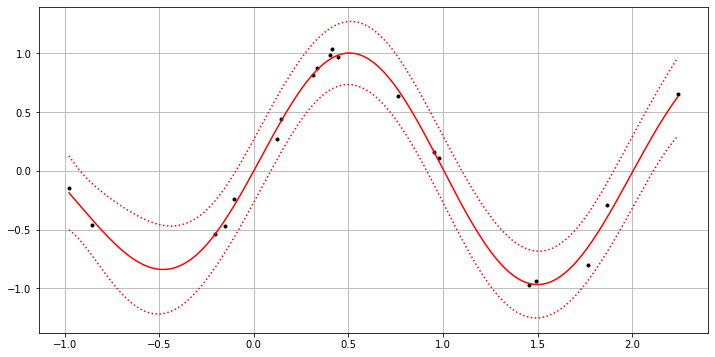

In [5]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = np.random.randn(N,1)
output_data = np.sin(np.pi * input_data) + 0.05 * np.random.randn(N,1)

gp = create_gp(input_data=input_data, 
               output_data=output_data, 
               initial_signal_variance=1.0,
               initial_lengthscale=1.0,
               initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)



## Bike Traffic Count Dataset

The following data is take from the UK Department of Transport figures counting how many cyclists crossed Vauxhall Bridge over Monday to Friday (week starting 31st July 2008). We note that the counts per hour are integers.

<class 'pandas.core.frame.DataFrame'>


,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,31,70,186,351,194,65,23,30,29,22,31,34,59,68,41,23,14,5,4
1,40,64,203,406,201,59,26,32,36,23,31,39,66,73,52,27,15,11,4
2,29,62,194,347,168,58,35,41,31,29,37,39,70,76,30,16,13,12,8
3,35,55,155,318,166,51,43,34,40,21,25,34,52,59,31,21,8,13,5
4,33,44,121,243,139,48,35,44,34,37,27,35,44,52,27,21,16,10,7


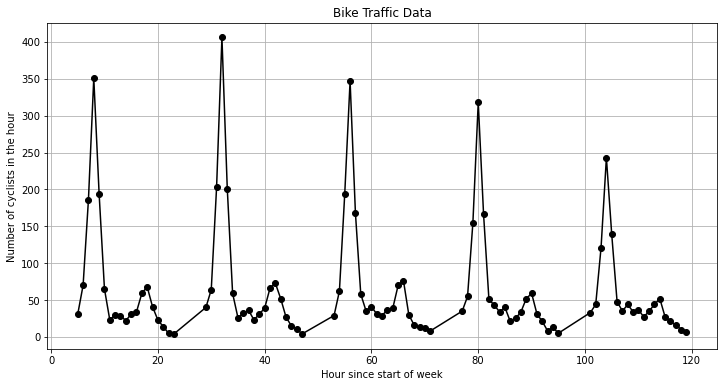

In [10]:
bike_data = pd.read_csv('traffic_data_week_2008_07_31.csv')
bike_data = bike_data.drop([5,6])
print(type(bike_data))
# counts = bike_data.as_matrix().flatten()

counts = bike_data.values.flatten()
times = np.zeros(bike_data.shape)
for n, r in bike_data.iterrows():
    times[n,:] = bike_data.columns.astype(np.float64) + (n*24)
times = times.flatten()

bike_counts = counts[:,np.newaxis]
bike_times = times[:,np.newaxis]

plt.figure(figsize=[12,6])
plt.plot(bike_times, bike_counts, 'ko-')
plt.grid(True)
plt.title('Bike Traffic Data')
plt.xlabel('Hour since start of week')
plt.ylabel('Number of cyclists in the hour')

bike_data

Next we run the GP code with a squared exponential kernel on the bike count data

input (95, 1)
outut (95, 1)
Before Optimisation:
signal_variance = 1.0
lengthscale = 1.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 170865.7284377394
  opt iter   200: objective = 1974.7006453601296
  opt iter   400: objective = 1002.7616672497686
  opt iter   600: objective = 769.091789456646
  opt iter   800: objective = 687.3504092835071
  opt iter  1000: objective = 653.8017301622682
  opt iter  1200: objective = 638.9149470729828
  opt iter  1400: objective = 632.0909944106796
  opt iter  1600: objective = 628.9576378086274
  opt iter  1800: objective = 627.54844814366
Final iter  1999: objective = 626.9384260486811

After Optimisation:
signal_variance = 162.428
lengthscale = 4.22954
sigma_noise_squared = 6687.03



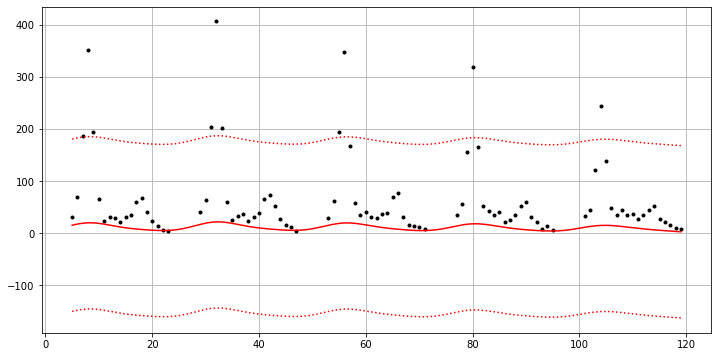

In [11]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts

print('input',input_data.shape)
print('outut',output_data.shape)

gp = create_gp(input_data=input_data, 
               output_data=output_data, 
               initial_signal_variance=1.0,
               initial_lengthscale=1.0,
               initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)



The choice of kernal can be quite important when building a gaussian process. The kernel specifies which functions are likely under the gaussian process prior and hence determines the generalisation properties of the model. The kernel builds a function to represent the probability distribution of using the sample data by condidering its prior.

The bike traffic dataset follows a periodic pattern which is not modelled by the squared exponential kernal. In order to better model such data the kernal needs to consider repetitive periods in the similarity function. A way to do this is to use a periodic kernel which takes in the hyperparemeter period to model functions which repeat themeselves.

## Switch to using periodic kernel

Now we will implement the periodic kernel

**The periodic kernel is defined as:**

$$
K(x_i, x_j) = \sigma_{\mathrm{f}}^{2} \exp\!\left( - 2 \gamma \left[\sin\left(\frac{\pi}{T} \sqrt{\|x_i - x_j\|^2} \right)\right]^2 \right)
$$

**Hyperparameters:**
- Signal variance $\sigma_{\mathrm{f}}^2$ (positive)
- Inverse Lengthscale $\gamma = 1 / \ell^2$ (positive)
- Period $T$ (positive)

In [12]:
def get_euclid_dist(t_X, t_Z):
    #t_inv_lengthscale_squared = 1.0 / tf.square(t_lengthscale)
    xx = tf.reduce_sum(t_X * t_X, axis=1, keep_dims=True)
    zz = tf.reduce_sum(t_Z * t_Z, axis=1, keep_dims=True)
    return xx + tf.transpose(zz) - 2.0 * tf.matmul(t_X, t_Z, transpose_b=True)

In [13]:
import math as m

def create_periodic_kernel(t_X1, t_X2, t_signal_variance, t_gamma, t_period):
    #dist_x1x2_sq = get_lengthscale_euclid_sq_dist(t_X1, t_X2, t_lengthscale)
    
    
    K = get_euclid_dist(t_X1, t_X2)
    sess = tf.Session()
#     import math as m

    pi = tf.constant(m.pi,dtype=dtype)
    

    
    K = tf.sqrt(K)
#     print('K',K.shape)
    
    piGamma = pi/t_period
    
    sinFsqr = tf.sin((piGamma)*K)**2
 
    
    return t_signal_variance*tf.exp(-2*t_gamma*sinFsqr)
    # Add code to this function..

# Modify this function as appropriate..
def create_periodic_gp(input_data, 
                       output_data, 
                       initial_signal_variance,
                       initial_gamma,
                       initial_period,
                       initial_sigma_noise_sq):

    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    #t_lengthscale = create_positive_variable(initial_lengthscale)
    t_gamma = create_positive_variable(initial_gamma)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    t_period = create_positive_variable(initial_period)
    
    print('t_period',t_period)
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'sigma_noise_squared': t_sigma_noise_sq,
                           'gamma':t_gamma,
                           'period':t_period}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    #sess = tf.Session()
    #print('initial_sigma_noise_sq',initial_sigma_noise_sq)
    
    kernel_creation_function = lambda t_X1, t_X2: \
        create_periodic_kernel(t_X1=t_X1, 
                                  t_X2=t_X2,
                                  t_signal_variance=t_signal_variance,
                                  t_gamma=t_gamma,
                                  t_period=t_period)
                                
                        

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)
    

    
    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    t_L_xx = tf.cholesky(t_K_xx)

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))

    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
    # Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_Y, lower=True)))

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) 
                    #+ 0.5 * tf.square(tf.log(t_lengthscale)) 

    half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)

    # Evaluate the NEGATIVE (since we will minimise) marginal log likelihood as
    # the objective for training the hyperparameters
    t_neg_log_likelihood = half_log_two_pi * dtype_convert(t_D) * dtype_convert(t_N) \
                         + 0.5 * dtype_convert(t_D) * t_log_det \
                         + t_Kinv_YYtranspose + t_hyper_prior + t_noise_prior

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_Y)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Periodic Gaussian Process',
            t_objective=t_neg_log_likelihood,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp

We will now run the session

t_period Tensor("Exp_3:0", shape=(), dtype=float64)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Before Optimisation:
signal_variance = 1.0
sigma_noise_squared = 1.0
gamma = 1.0
period = 24.0

  opt iter     0: objective = 136405.73566419657
  opt iter   200: objective = 1248.6197379094972
  opt iter   400: objective = 853.1950298910433
  opt iter   600: objective = 693.347954861752
  opt iter   800: objective = 612.8550618549094
  opt iter  1000: objective = 568.317167323635
  opt iter  1200: objective = 542.1519676414426
  opt iter  1400: objective = 526.1513969031098
  opt iter  1600: objective = 516.1081350617002
  opt iter  1800: objective = 509.70753318150844
Final iter  1999: objective = 505.6189130611716

After Optimisation:
signal_variance = 3292.86
sigma_noise_squared = 166.304
gamma = 14.8995
period = 24.0078



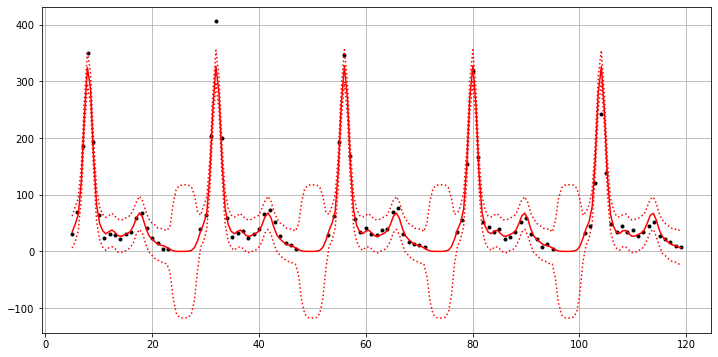

In [14]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts

gp = create_periodic_gp(input_data=input_data, 
                        output_data=output_data, 
                        initial_signal_variance=1.0,
                        initial_gamma=1.0,
                        initial_period=24.0,
                        initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)

In [15]:
def numpy_period_exp_kernel(X, signal_variance, gamma,period):
    
    # Add code using for loops to generate K(X, X)
    #k = exp(-(x-))
    #build symetric matrix calculating the squared kernal between each point

    K = np.zeros((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            xDiffsqrt =  (np.absolute(X[i]-X[j]))**2
            
            #print(xDiffsqrt)
            K[i,j] = xDiffsqrt
            #K[i,j] = signal_variance*np.exp((-1/(2*lengthscale**2))*xDiffsqrt)
    print('K numpy',K)
    K = np.sqrt(K)
    sinK = np.sin((np.pi/period)*K)**2

    
    return signal_variance*np.exp(-2*gamma*sinK)

# Testing part:
gamma = (1/2.3)
signal_variance = 1.4
period = 10


N = 5
X = np.random.randn(N,1)

#print(X)
tf.reset_default_graph()
with tf.Session() as session:
    t_gamma = tf.constant(gamma, dtype=dtype)
    t_signal_variance = tf.constant(signal_variance, dtype=dtype)
    t_period = tf.constant(period, dtype=dtype)
    
    #t_signal_variance
    
    t_X = tf.constant(X, dtype=dtype)
    
    t_K = create_periodic_kernel(t_X1=t_X, 
                                    t_X2=t_X, 
                                    t_signal_variance=t_signal_variance,
                                    t_gamma=t_gamma,
                                    t_period = t_period)
    
    print('TensorFlow K =\n', session.run(t_K))
    
    numpy_K = numpy_period_exp_kernel(X=X, 
                                      signal_variance=signal_variance, 
                                      gamma=gamma,
                                      period= period)
    
    print('My numpy checking code K = \n', numpy_K)

TensorFlow K =
 [[1.4        1.20485383 1.32924221 1.37314491 1.39871381]
 [1.20485383 1.4        1.3607794  1.079699   1.17868456]
 [1.32924221 1.3607794  1.4        1.22970021 1.31050972]
 [1.37314491 1.079699   1.22970021 1.4        1.38342886]
 [1.39871381 1.17868456 1.31050972 1.38342886 1.4       ]]
K numpy [[0.         1.86020995 0.61671865 0.2273772  0.01071342]
 [1.86020995 0.         0.33475571 3.38830899 2.15326505]
 [0.61671865 0.33475571 0.         1.59303579 0.790001  ]
 [0.2273772  3.38830899 1.59303579 0.         0.13937918]
 [0.01071342 2.15326505 0.790001   0.13937918 0.        ]]
My numpy checking code K = 
 [[1.4        1.20485383 1.32924221 1.37314491 1.39871381]
 [1.20485383 1.4        1.3607794  1.079699   1.17868456]
 [1.32924221 1.3607794  1.4        1.22970021 1.31050972]
 [1.37314491 1.079699   1.22970021 1.4        1.38342886]
 [1.39871381 1.17868456 1.31050972 1.38342886 1.4       ]]


## Gaussian Process Regression with Poisson Likelihood

The Poisson distribution is a probability distribution over counts within a fixed time period (positive integer values). The likelihood function is defined in terms of a positive rate parameter $\lambda > 0$ as

$$
p(y) = \frac{\lambda^{y} \exp(-\lambda)}{y!}, \; y \in [0,1,2,3,\dots]
$$

In a similar manner to the GP for binary classification, we can define a GP with a Poisson likelihood

$$
p(Y, f \mid X, \theta) = p(Y \mid f) \, p(f \mid X, \theta)
$$

where the $\lambda$ parameter in the Poisson likelihood is a function of $f$. Assuming iid data we have

$$
p(Y \mid X) = \prod_{n=1}^{N} \frac{{\lambda(f_n)}^{y_n} \exp(-\lambda(f_n))}{y_n!}
$$

We put a GP prior over $f$

$$
p(f \mid X, \theta) = \mathcal{N}(f \mid 0, \kappa(X,X;\theta)
$$

however this makes the value of $f$ a real number. We map this to a positive number through the exponential function such that

$$
\lambda(f_n) = \exp(f_n) \; \Rightarrow \; \lambda(f_n) \in \mathcal{R}^{+} 
$$

To calculate the marginal log likelihood we must integrate out the function parameters $f$ such that

$$
\log p(Y \mid X, \theta) = \log \int p(Y \mid f) \, p(f \mid X, \theta) \mathrm{d}f
$$

As for the classification GP, we cannot perform this operation in closed form so we use a variational approximation 

$$
q(f) = \prod_n \mathcal{N}(f_n \mid \mu_n, \sigma^2)
$$

with a mean variational parameter $\mu_n$ for each $f_n$ and a shared variance $\sigma^2$.

The variational lower bound can then be defined as 

$$
\mathcal{L} =  \sum_n \mathbb{E}_{q(f_n)}\!\left[ \log p(y_n \mid f_n) \right] - \mathrm{KL}\big[ q(f) \,\|\, p(f\mid X, \theta) \big]
$$

We now look at the two terms in the lower bound and the next task is to derive expressions related to the expectation and the KL divergence.


The expression for the KL divergence between two **univariate** Gaussian distributions is:
    
$$
\mathrm{KL}\left[\mathcal{N}(x \mid \mu_0, \sigma_0^2) \| \mathcal{N}(x \mid \mu_1, \sigma_1^2) \right] =
\int \mathcal{N}(x \mid \mu_0, \sigma_0^2) \log \frac{\mathcal{N}(x \mid \mu_0, \sigma_0^2)}{\mathcal{N}(x \mid \mu_1, \sigma_1^2)} \mathrm{d}x
$$

**the derivation is given below**


We have 2 normal distributions p(x) and q(x)

$$
p(x) = \mathcal{N}(\mu, \sigma^2)
$$

$$
q(x) = \mathcal{N}(m, s^2)
$$

The KL divergence of the distributions is equal

$$
\int p(x)log\frac{p(x)}{q(x)}dx
$$

Expanding out the distribution gives

$$
\int p(x) log\frac{\frac{1}{2\pi\sigma^2}\exp(-\frac{(x-\mu)^2}{2\sigma^2})} {\frac{1}{2\pi s^2}\exp(-\frac{(x-m)^2}{2s^2})}dx
$$

which can be simplified to

$$
p(x) log(\frac{s^2}{\sigma^2})^\frac{1}{2}dx + \int p(x)[-\frac{(x-\mu)^2}{2\sigma^2}+ \frac{(x-m)^2}{2s^2}]
$$

and

$$
\frac{1}{2}log (\frac{s^2}{\sigma^2}) + \frac{1}{2\sigma^2}[-\int(x-\mu)^2p(x)dx] + \frac{1}{2s^2}\int(x-m)^2p(x)dx
$$

$$
\frac{1}{2} log\frac{s^2}{\sigma^2}-\frac{\sigma^2}{2\sigma^2}+\frac{1}{2s^2}\int(x-\mu+\mu-m)^2 p(x) dx ,
$$

$$
\frac{1}{2}log\frac{s^2}{\sigma^2}-\frac{1}{2}+\frac{1}{2s^2}[\int(x-\mu)^2p(x)dx + (\mu-m)^2\int p(x)dx+2(\mu-m)\int(x-\mu)p(x)dx]
$$

$$
\frac{1}{2}log \frac{s^2}{\sigma^2} - \frac{1}{2}+\frac{1}{2s^2}[\sigma^2+(\mu-m)^2]
$$

$$
\frac{1}{2}[log \frac{s^2}{\sigma^2}-1+\frac {\sigma^2+(\mu-m)^2}{s^2}]
$$

The corresponding KL divergence for **multivariate** Gaussians is given by

$$
\mathrm{KL}\left[\mathcal{N}(x \mid \mu_0, \Sigma_0) \| \mathcal{N}(x \mid \mu_1, \Sigma_1) \right] = 
\frac{1}{2} \left( \mathrm{Tr}[\Sigma_1^{-1} \Sigma_0] + (\mu_1 - \mu_0)^{T}\Sigma_1^{-1}(\mu_1 - \mu_0) - N + \log \frac{\det \Sigma_1}{\det \Sigma_0} \right), \;\text{for}\; x \in \mathbb{R}^{N}
$$

The following expression is the KL divergence between the approximating distrbution and our Gaussian process prior on $f$

$$
\mathrm{KL}\left[ q(f) \| p(f\mid X, \theta) \right] = \frac{1}{2} \left( \mathrm{Tr}[K^{-1}(\sigma^2 I + \mu \mu^T)] - N + \log \det K - N \log{\sigma^2} \right), \; K = \kappa(X,X;\theta)
$$


## The Lower Bound for the Poisson GP

The final lower bound for the Poisson GP is therefore given by

$$
\mathcal{L} =  \sum_n \left\{ y_n \mu_n - \exp\left( \frac{2\mu_n + \sigma_n^2}{2} \right) - \log(y_n!) \right\} 
- \frac{1}{2} \left( \mathrm{Tr}[K^{-1}(\sigma^2 I + \mu \mu^T)] - N + \log \det K - N \log{\sigma^2} \right)
$$

We will now update the GP code from above to optimise the negative lower bound of the Poisson GP. we will have to introduce extra TensorFlow variables for the variational parameters $\{\mu_n\}$ and $\sigma^2$. we will **initialise** the means as $\mu_n = \log(y_n)$ and the variance $\sigma^2 = 1$ (remember they are variables and not constants).

**IMPORTANT: we will also need to update the predictive posterior. For the purposes of plotting the result it is sufficent to evaluate the mean of $f^{*}$ and plot $\lambda(\mu_f^{*}) = \exp(\mu_{f}^{*})$ against the training data since $\lambda$ is the mean of a Poisson distribution.**


Now we will run the Poisson GP with a periodic kernel.

In [21]:
# A wrapper function to create a real number variable (-infinity, infinity)
# with an initial value that will be optimised by tensorflow.
def create_real_variable(initial_value):
    return tf.Variable(initial_value, dtype=dtype)

# A wrapper function to create a positive variable (0, infinity) by
# taking the exp() of a real number - this will map the real range to
# the set of positive numbers.
def create_positive_variable(initial_value):
    assert initial_value > 0.0
    return tf.exp(tf.Variable(np.log(initial_value), dtype=dtype))
    #return tf.exp(tf.Variable(np.log(initial_value), dtype=tf.float32))
    
# A Gaussian Process class to keep all the parts of the model we need
# grouped together
class GP:
    def __init__(self,
                 description,
                 t_objective,
                 create_prediction_function,
                 t_prediction_placeholder,
                 t_prediction_mean,
                 t_prediction_var,
                 t_input=None,
                 t_output=None,
                 hyperparameter_dict={}):

        self._description = description
        self._t_objective = t_objective
        self._create_prediction_function = create_prediction_function
        self._t_prediction_placeholder = t_prediction_placeholder
        self._t_prediction_mean = t_prediction_mean
        self._t_prediction_var = t_prediction_var
        self._t_input = t_input
        self._t_output = t_output
        self._hyperparameter_dict = hyperparameter_dict

    @property
    def description(self): return self._description

    @property
    def t_objective(self): return self._t_objective

    @property
    def t_prediction_placeholder(self): return self._t_prediction_placeholder

    @property
    def t_prediction_mean(self): return self._t_prediction_mean

    @property
    def t_prediction_var(self): return self._t_prediction_var

    @property
    def t_input(self): return self._t_input

    @property
    def t_output(self): return self._t_output

    @property
    def hyperparameter_dict(self): return self._hyperparameter_dict

    def create_prediction(self, tf_input):
        return self._create_prediction_function(tf_input)
    

# Create a GP regression model by specifying the input and output data, as (N x 1) matrices,
# and the initial values for the hyperparameters (these will be turned into tensorflow variables
# and optimised).



def create_gp(input_data, 
              output_data, 
              initial_signal_variance,
              initial_gamma,
              initial_period,
              initial_sigma_noise_sq,
              initial_Variance):

    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    #t_lengthscale = create_positive_variable(initial_lengthscale)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    t_muN = create_real_variable(np.log(output_data))
    t_Variance = create_positive_variable(initial_Variance)
    t_gamma = create_positive_variable(initial_gamma)
    t_period = create_positive_variable(initial_period)

    sess = tf.Session()
    
    #print('t_signal_variance',sess.run(t_signal_variance))
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'sigma_noise_squared': t_sigma_noise_sq,
                           'Variance':t_Variance}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    kernel_creation_function = lambda t_X1, t_X2: \
        create_periodic_kernel(t_X1=t_X1, 
                                  t_X2=t_X2,
                                  t_signal_variance=t_signal_variance,
                                  t_gamma=t_gamma,
                                  t_period=t_period)
    
    
   

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)
    
    t_sec1 = tf.reduce_sum(tf.matmul(t_Y,t_muN,transpose_a=True))-tf.reduce_sum(tf.exp((2*t_muN +t_Variance)/2))
    
#     with tf.Session() as sess:
#         tf.initialize_all_variables().run()
    
#         print('kernal 2', sess.run(t_K_xx))
    print(t_K_xx)
    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    t_L_xx = tf.cholesky(t_K_xx)
    
    #print('cholesky',t_K_xx)

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))

    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
    # Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_NLogSigma = dtype_convert(t_N) * tf.log(t_Variance)
    
    print()
    #been updated
    
    Kinv = tf.matrix_inverse(t_K_xx)
    sigI = t_Variance*tf.eye(t_N, dtype=dtype) 
    munmuntran = tf.matmul(t_muN,t_muN, transpose_b=True)
    sigImun = sigI + munmuntran
    t_Kinv_YYtranspose = tf.trace(tf.matmul(Kinv,sigImun))
    

    t_neg_log_likelihood = t_sec1-0.5*(t_Kinv_YYtranspose - dtype_convert(t_N) +t_log_det-t_NLogSigma)
    t_neg_log_likelihood = -t_neg_log_likelihood
    
    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        #change t_Y to mu
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_muN)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Gaussian Process',
            t_objective=t_neg_log_likelihood,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp


# Print out the current values of the hyperparameters
def print_hyperparameters(gp, session):
    for (k, v) in gp.hyperparameter_dict.items():
        print('{} = {:.6}'.format(k, session.run(v)))
    print('')


# Plot the predicitve posterior for the provide input values (num_test_points x 1 matrix) 
def plot_gp_predictions(gp, session, input_values):
    # Ensure N* x 1 input variable
    if input_values.ndim == 1:
        input_values = input_values[:,np.newaxis]
    
    feed_dict = {gp.t_prediction_placeholder: input_values}
    
    pred_mean, pred_var = session.run((gp.t_prediction_mean, 
                                       gp.t_prediction_var), 
                                      feed_dict=feed_dict)
    
    plt.figure(figsize=[12,6])
    plt.plot(session.run(gp.t_input), session.run(gp.t_output), 'k.')
    plt.plot(input_values, np.exp(pred_mean), 'r-')
    plt.plot(input_values, np.exp(pred_mean + 2.0 * np.sqrt(pred_var)), 'r:')
    plt.plot(input_values, np.exp(pred_mean - 2.0 * np.sqrt(pred_var)), 'r:')
    plt.grid(True)

    

Tensor("add_2:0", shape=(95, 95), dtype=float64)

Before Optimisation:
signal_variance = 1.0
sigma_noise_squared = 1.0
Variance = 0.5

  opt iter     0: objective = -20899.806515747336
  opt iter   200: objective = -22553.992917648917
  opt iter   400: objective = -22519.498888905004
  opt iter   600: objective = -22565.7417171544
  opt iter   800: objective = -22574.296839011575
  opt iter  1000: objective = -22573.203216686863
  opt iter  1200: objective = -22560.360394860327
  opt iter  1400: objective = -22567.615758853295
  opt iter  1600: objective = -22559.135362536555
  opt iter  1800: objective = -22556.92256504487
Final iter  1999: objective = -22571.00514621689

After Optimisation:
signal_variance = 8.36197
sigma_noise_squared = 0.028144
Variance = 0.0091621



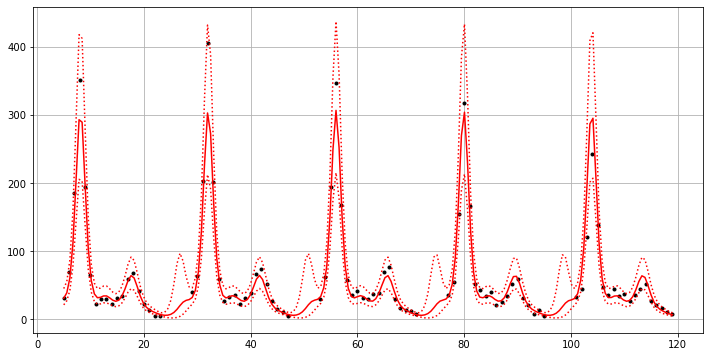

In [22]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts

gp = create_gp(input_data=input_data, 
               output_data=output_data, 
               initial_signal_variance=1.0,
               initial_gamma=1.0,
               initial_period=24.0,
               initial_sigma_noise_sq=1.0,
               initial_Variance=0.5)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)

Using the periodic kernel is better at capturing the spikes at each period. The mean of the function is much closer to the peak data point reletive to squared exponential kernel. The standard deviation bands for the periodic kernel are generally closer than the sd bands for the squared kernel. The periodic kernal is better at modelling the extreme values because it is considering the patterns in data at each period whereas the squared kernal is attempting to model a smoother simlarity in between the points so will be worse at representing the peaks.
 
The poisson distribution is a better distribution to model the bike data because it only produces positive values and number cyclists is always gona be a positive number 
